# CHEOPS and TESS light curve plots

In [1]:
%matplotlib inline

In [9]:
import seaborn as sb

from numpy import array, argsort, percentile, median
from numpy.random import permutation

from matplotlib.pyplot import subplots, setp

from pytransit.orbits import fold, epoch
from pytransit.utils.downsample import downsample_time_1d

from src.kelt1 import read_mcmc, AAPGW, AAOCW
from src import FinalLPF

In [3]:
lpf = FinalLPF('b')

In [4]:
d02 = read_mcmc('results/03b_fin_emission_and_constrained_ev.nc')
pvp = permutation(d02)[:100]
t0, p = median(pvp, 0)[:2]

## Calculate the TESS model

In [5]:
gp = lpf._lnlikelihood_models[1]
slt = lpf.lcslices[8]
flux_obs_tess = lpf.ofluxa[slt]
time_tess = lpf.timea[slt]
phase_tess = 24*fold(time_tess, p, t0, 0.5)
flux_mod_tess_dist = lpf.transit_model(pvp)[:, slt]
gp_tess_dist = array([gp.predict_baseline(pv)[slt] for pv in pvp])
bl_tess_dist = lpf.baseline(pvp)[:, slt]

flux_cor_tess = median(flux_obs_tess / bl_tess_dist - gp_tess_dist + 1, 0)
flux_mod_tess = percentile(flux_mod_tess_dist, [50, 16, 84], 0)

## Calculate the CHEOPS model

In [7]:
slc = slice(0, lpf.lcslices[7].stop)
time_cheops = lpf.timea[slc]
phase_cheops = 24*fold(time_cheops, p, t0, 0.5)
flux_obs_cheops = lpf.ofluxa[slc]
flux_mod_cheops_dist = lpf.transit_model(pvp)[:,slc]
bl_cheops_dist = lpf.baseline(pvp)[:,slc]

flux_cor_cheops = median(flux_obs_cheops / bl_cheops_dist, 0)
flux_mod_cheops = percentile(flux_mod_cheops_dist, [50, 16, 84], 0)

## Create the final plot

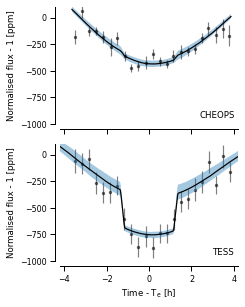

In [10]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(2, 1, figsize=(AAOCW, 1.2*AAOCW), sharex='all', sharey='all')
    
    # CHEOPS
    # ------
    sids = argsort(phase_cheops)
    bp, bf, be = downsample_time_1d(phase_cheops[sids], flux_cor_cheops[sids], 20 / 60, tmin=-4, tmax=4)
    axs[0].fill_between(phase_cheops[sids], *(1e6*(flux_mod_cheops[1:, sids]-1)), alpha=0.4)
    axs[0].errorbar(bp, 1e6*(bf-1), 1e6*be, fmt='.', c="k", alpha=0.5)
    axs[0].plot(phase_cheops[sids], 1e6*(flux_mod_cheops[0, sids]-1), 'k')
    
    # TESS
    # ----
    sids = argsort(phase_tess)
    bp, bf, be = downsample_time_1d(phase_tess[sids], flux_cor_tess[sids], 20 / 60, tmin=-4, tmax=4) 
    axs[1].fill_between(phase_tess[sids], *((1e6*(flux_mod_tess[1:, sids] - 1) - 350)), alpha=0.4)
    axs[1].errorbar(bp, 1e6*(bf-1)-350, 1e6*be, fmt='.', c="k", zorder=-1, alpha=0.5)
    axs[1].plot(phase_tess[sids], 1e6*(flux_mod_tess[0, sids] - 1) - 350, 'k')

    for i, ax in enumerate(axs):
        ax.text(0.98, 0.05, ('CHEOPS', 'TESS')[i], ha='right', transform=ax.transAxes)
    setp(axs, ylabel='Normalised flux - 1 [ppm]', xlim=(-4.2, 4.2), ylim=(-1000, 100))
    setp(axs[1], xlabel='Time - T$_\mathrm{e}$ [h]')
    sb.despine(offset=5)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.12)
    fig.savefig('plots/cheops_light_curve.pdf')

---

<center>&copy;2022 Hannu Parviainen</center>